# Classification and Regression, from linear and logistic regression to neural networks

### Authors

Britt Haanen
Pragay Shourya Moudgil

### Preamble

The code below imports the required packages.

In [6]:
# Numpy
import numpy as np

# pandas
import pandas as pd

# scikit-learn
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn import datasets
from sklearn.metrics import confusion_matrix

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#tensorflow
import tensorflow as tf

# tqdm
from tqdm import tqdm

# multiprocessing
import multiprocessing as mp

#warnings
import warnings
warnings.filterwarnings('ignore')

# joblib
from joblib import Parallel, delayed


from IPython.display import clear_output

# json
import json

# seaborn
import seaborn as sns

import sys

print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Scikit-learn:", sklearn.__version__)
print("json:", json.__version__)
print("Matplotlib:", matplotlib.__version__)
print("TensorFlow:", tf.__version__)
print("Seaborn:", sns.__version__)

Python: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
NumPy: 1.26.4
Pandas: 2.2.2
Scikit-learn: 1.4.2
json: 2.0.9
Matplotlib: 3.8.4
TensorFlow: 2.18.0
Seaborn: 0.13.2


The code snippets below are recycled from Project 1, which may be found at https://github.com/BrittHaanen15/Project1_FinalSubmission

In [2]:
class DataGenerator():

    def __init__(self, x, y):
        """
        Initialize the object with x and y coordinates.

        Parameters:
        x (float): The x-coordinate.
        y (float): The y-coordinate.
        """
        self.x, self.y = x, y


    def FrankeFunction(self):
        #Code source: M Hjorth-Jensen, Project 1, Assignment description, September 2024

        term1 = 0.75*np.exp(-(0.25*(9*self.x-2)**2) - 0.25*((9*self.y-2)**2))
        term2 = 0.75*np.exp(-((9*self.x+1)**2)/49.0 - 0.1*(9*self.y+1))
        term3 = 0.5*np.exp(-(9*self.x-7)**2/4.0 - 0.25*((9*self.y-3)**2))
        term4 = -0.2*np.exp(-(9*self.x-4)**2 - (9*self.y-7)**2)

        self.frankf = term1 + term2 + term3 + term4
        
        return self.frankf

    def plot_franke(self, z = None, ax = None):
        
        if z is None:
            z = self.frankf
        # Plot the surface.
        surf = ax.plot_surface(self.x, self.y, z, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)

        # Customize the z axis.
        ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        
        return ax



In [26]:
# Utils:
def determine_X(poly_deg, x, y, intercept = False):
    """
    Generates the design matrix X for the Franke Function based on the given polynomial degree.
    Parameters:
    poly_deg (int): The degree of the polynomial.
    x (array-like): The x-coordinates of the data points.
    y (array-like): The y-coordinates of the data points.
    intercept (bool, optional): If False, the intercept term (column of ones) is removed from the design matrix. Default is False.
    Returns:
    numpy.ndarray: The design matrix X with shape (len(x), (poly_deg+1)*(poly_deg+2)/2) if intercept is True, 
                    otherwise with shape (len(x), (poly_deg+1)*(poly_deg+2)/2 - 1).
    """
    
    #Code based on source: M Hjorth-Jensen. Week 35: From ordinary linear regression to ridge and lasso regression. Lecture notes, August 2024.

    X = np.ones((len(x),int((poly_deg+1)*(poly_deg+2)/2)))
    for i in range(1,poly_deg+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    if intercept is False:
        X = X[:,1:]
    return X

def scaling_mean(X_train, X_test):
    mean = np.mean(X_train, axis = 0)
    return X_train - mean, X_test - mean

def prep_train_test(X, z, train_size = 0.66):

    return train_test_split(X, z, train_size=train_size)


def evaluate_stats(y_pred, y_input):
    return [np.mean( np.mean((y_input[:, np.newaxis] - y_pred)**2, axis=1, keepdims=True)),
            np.mean( (y_input - np.mean(y_pred, axis=1, keepdims=True))**2),
            np.mean( np.var(y_pred, axis=1, keepdims=True))
            ] 

In [27]:
class Metrics():

    def __init__(self, y_target, y_pred):
        
        self.y_target = y_target
        self.y_pred = y_pred


    def r2_score(self):
        a = self.y_pred - np.mean(self.y_pred)
        b = self.y_target - np.mean(self.y_target)
        return (np.sum(a * b)) ** 2 / (np.sum(a ** 2) * np.sum(b ** 2))

            
    
    def mean_squared_error(self):
        return (np.sum(np.square(self.y_target - self.y_pred ))/len(self.y_target))

In [ ]:
class OLS():

    def __init__(self, x, y, z, poly_deg, sk_learn = False):
        self.x, self.y, self.z, self.poly_deg, self.sk_learn = np.ravel(x), np.ravel(y), np.ravel(z), poly_deg, sk_learn

    def _beta(self, X, z):
        #calculate beta
        return (np.linalg.inv(X.T @ X) @ X.T ) @ z
    
    def predict(self, X_input):
        return X_input @ self.betahat_train 
    
    def fit(self, train_size = 0.66):
        
        X = determine_X(poly_deg=self.poly_deg, x = self.x, y= self.y, intercept = False)

        self.X_train, self.X_test, self.z_train, self.z_test = prep_train_test(X=X, z=self.z, train_size=train_size)

        # self.X_train, self.X_test = scaling_mean(self.X_train, self.X_test)
        
        if self.sk_learn is False:
            self.betahat_train = self._beta(X=self.X_train, z=self.z_train)

            return self.betahat_train
        else:
            self.model = linear_model.LinearRegression(fit_intercept=False).fit(self.X_train, self.z_train)
            return self.model
    
    def evaluate(self):

        if self.sk_learn is False:
            ztilde_train = self.predict(self.X_train)
            ztilde_test = self.predict(self.X_test)
        
        else:
            ztilde_train = self.model.predict(self.X_train)
            ztilde_test = self.model.predict(self.X_test)


        return [Metrics(ztilde_train, self.z_train).mean_squared_error(),
                Metrics(ztilde_test, self.z_test).mean_squared_error(),
                Metrics(ztilde_train, self.z_train).r2_score(),
                Metrics(ztilde_test, self.z_test).r2_score()]

In [29]:
class RidgeRegression():

    def __init__(self, x, y, z, poly_deg, ld):

        self.x, self.y, self.z, self.poly_deg, self.ld = np.ravel(x), np.ravel(y), np.ravel(z), poly_deg, ld

    def _beta(self, X, z, ld):
        #calculate beta for ridge
        xtxinv_r = np.linalg.inv((X.T.dot(X) + ld*np.identity(X.shape[1])))
        return xtxinv_r.dot(X.T).dot(z)

    def predict(self, X_input):
        return X_input @ self.betahat_train
    

    def fit(self, train_size = 0.66):
            
        X = determine_X(poly_deg=self.poly_deg, x = self.x, y= self.y, intercept = False)

        self.X_train, self.X_test, self.z_train, self.z_test = prep_train_test(X=X, z=self.z, train_size=train_size)

        # self.X_train, self.X_test = scaling_mean(self.X_train, self.X_test)
        
        self.betahat_train = self._beta(X=self.X_train, z=self.z_train, ld=self.ld)

        return self.betahat_train
    
    def evaluate(self):

        ztilde_train = self.predict(self.X_train)
        ztilde_test = self.predict(self.X_test)

        return [Metrics(ztilde_train, self.z_train).mean_squared_error(),
                Metrics(ztilde_test, self.z_test).mean_squared_error(),
                Metrics(ztilde_train, self.z_train).r2_score(),
                Metrics(ztilde_test, self.z_test).r2_score()]

### Part a

The class below was used to study the performance of several gradient descent methods on a simple polynomial $2 - 5x + 3x^2$. The MSE results of trying different batch sizes, learning rates, $\lambda$ and so on were plotted as seaborn figures and they may be viewed in the selected results folder. The overall results of these calculations are discussed in the report. 

In [31]:
class GradientDescent:
    
    """
    A class to perform gradient descent optimization for linear regression models.
    Attributes:
    -----------
    X : numpy.ndarray
        The input feature matrix.
    y : numpy.ndarray
        The target variable vector.
    n : int
        The number of samples in the dataset.
    Methods:
    --------
    __init__(X, y):
        Initializes the GradientDescent object with input features and target variable.
    __plain__(learning_rate, epochs, type, labda, optimiser):
        Performs plain gradient descent optimization.
    __stochastic__(learning_rate, epochs, batch_size, type, labda, optimiser):
        Performs stochastic gradient descent optimization.
    """

#The code below was aided by: M Hjorth-Jensen, exercisesweek41, instruction, October 2024

    def __init__(self, X, y):
        #Data is automatically scaled
        scaler = StandardScaler()
        self.y = scaler.fit_transform(y)
        self.X = X
        self.n = len(self.y)
    
    #Perform regular gradient descent
    def __plain__(self, learning_rate, epochs, type, labda, optimiser):
        #randomly initialise betas
        np.random.seed(5)
        betas = np.random.randn(self.X.shape[1],1)

        #perform gradient descent
        if optimiser == 'None':

            for i in range(epochs):
                #compute gradient
                if type == 'OLS':
                    gradient = (-2.0/self.n)*self.X.T@(self.y - self.X@betas)
                elif type == 'Ridge':
                    gradient = 2.0/self.n*self.X.T @ (self.X @ betas-self.y)+2*labda*betas
                else:
                    print("Unknown regression type, choose OLS or Ridge")

                #update betas
                betas -= learning_rate*gradient


        elif optimiser == 'Momentum':
            #set momentum parameters
            change = 0.0
            delta_momentum = 0.3

            for iter in range(epochs):
                # calculate gradient
                gradients = 2.0/self.n*self.X.T @ (self.X @ betas-self.y)
                # calculate update
                new_change = learning_rate*gradients+delta_momentum*change
                # take a step
                betas -= new_change
                # save the change
                change = new_change


        elif optimiser == 'Adagrad':
            delta  = 10e-8
            Giter = 0.0

            #perform gradient descent
            for epoch in range(epochs):
                #compute gradient
                if type == 'OLS':
                    gradient = (-2.0/self.n)*self.X.T@(self.y - self.X@betas)
                elif type == 'Ridge':
                    gradient = 2.0/self.n*self.X.T @ (self.X @ betas-self.y)+2*labda*betas
                else:
                    print("Unknown regression type, choose OLS or Ridge")

                #update betas
                Giter += gradient*gradient
                update = gradient*learning_rate/(delta+np.sqrt(Giter))
                betas -= update


        elif optimiser == 'Rmsprop':
            #set RMSProp parameters
            rho = 0.99
            delta  = 1e-8
            Giter = 0.0

            #perform gradient descent
            for epoch in range(epochs):
                
                #compute gradient
                if type == 'OLS':
                    gradient = (-2.0/self.n)*self.X.T@(self.y - self.X@betas)
                elif type == 'Ridge':
                    gradient = 2.0/self.n*self.X.T @ (self.X @ betas-self.y)+2*labda*betas
                else:
                    print("Unknown regression type, choose OLS or Ridge")

                #update betas
                Giter = (rho*Giter+(1-rho)*gradient*gradient)
                update = gradient*learning_rate/(delta+np.sqrt(Giter))
                betas -= update


        elif optimiser == 'Adam':
            #setting the Adam parameters
            beta1 = 0.9
            beta2 = 0.999
            delta  = 1e-7
            iter = 0
            first_moment = 0.0
            second_moment = 0.0

            #perform gradient descent
            for epoch in range(epochs):
                iter += 1

                #compute gradient
                if type == 'OLS':
                    gradient = (-2.0/self.n)*self.X.T@(self.y - self.X@betas)
                elif type == 'Ridge':
                    gradient = 2.0/self.n*self.X.T @ (self.X @ betas-self.y)+2*labda*betas
                else:
                    print("Unknown regression type, choose OLS or Ridge")

                #compute moments
                first_moment = beta1*first_moment + (1-beta1)*gradient
                second_moment = beta2*second_moment+(1-beta2)*gradient*gradient
                first_term = first_moment/(1.0-beta1**iter)
                second_term = second_moment/(1.0-beta2**iter)
                #update betas
                update = learning_rate*first_term/(np.sqrt(second_term)+delta)
                betas -= update

        return betas
    

    def __stochastic__(self, learning_rate, epochs, batch_size, type, labda, optimiser):
        num_batches = int(self.n/batch_size)

        #randomly initialise betas
        np.random.seed(5)
        betas = np.random.randn(self.X.shape[1],1)

        #perform gradient descent
        if optimiser == 'None':

            for i in range(epochs):
                for j in range(num_batches):
                    #Sample minibatch from the data
                    batch_indices = np.random.randint(low=0, high=self.n, size=batch_size)
                    X_batch = self.X[batch_indices,:]
                    y_batch = self.y[batch_indices,:]

                    #compute gradient
                    if type == 'OLS':
                        gradient = (-2.0/self.n)*X_batch.T@(y_batch - X_batch@betas)
                    elif type == 'Ridge':
                        gradient = 2.0/self.n*X_batch.T @ (X_batch @ betas-y_batch)+2*labda*betas
                    else:
                        print("Unknown regression type, choose OLS or Ridge")

                    #update betas
                    betas -= learning_rate*gradient


        elif optimiser == 'Momentum':
            #set momentum parameters
            change = 0
            delta = 0.3

            #perform gradient descent
            for epoch in range(epochs):
                for i in range(num_batches):
                    #Sample minibatch from the data
                    batch_indices = np.random.randint(low=0, high=self.n, size=batch_size)
                    X_batch = self.X[batch_indices,:]
                    y_batch = self.y[batch_indices,:]

                   #compute gradient
                    if type == 'OLS':
                        gradient = (-2.0/self.n)*X_batch.T@(y_batch - X_batch@betas)
                    elif type == 'Ridge':
                        gradient = 2.0/self.n*X_batch.T @ (X_batch @ betas-y_batch)+2*labda*betas
                    else:
                        print("Unknown regression type, choose OLS or Ridge")

                    #update betas
                    new_change = learning_rate*gradient+delta*change
                    # take a step
                    betas -= new_change
                    # save the change
                    change = new_change



        elif optimiser == 'Adagrad':
            delta  = 1e-8
            for epoch in range(epochs):
                Giter = 0.0
                for i in range(num_batches):
                    batch_indices = np.random.randint(low=0, high=self.n, size=batch_size)
                    X_batch = self.X[batch_indices,:]
                    y_batch = self.y[batch_indices,:]

                    #compute gradient
                    if type == 'OLS':
                        gradient = (-2.0/self.n)*X_batch.T@(y_batch - X_batch@betas)
                    elif type == 'Ridge':
                        gradient = 2.0/self.n*X_batch.T @ (X_batch @ betas-y_batch)+2*labda*betas
                    else:
                        print("Unknown regression type, choose OLS or Ridge")

                    Giter += gradient*gradient
                    update = gradient*learning_rate/(delta+np.sqrt(Giter))
                    betas -= update


        elif optimiser == 'Rmsprop':
            #set RMSProp parameters
            delta = 1e-8
            rho = 0.99

            #perform gradient descent
            for epoch in range(epochs):
                Giter = 0.0
                for i in range(num_batches):
                    #Sample minibatch from the data
                    batch_indices = np.random.randint(low=0, high=self.n, size=batch_size)
                    X_batch = self.X[batch_indices,:]
                    y_batch = self.y[batch_indices,:]

                    #compute gradient
                    if type == 'OLS':
                        gradient = (-2.0/self.n)*X_batch.T@(y_batch - X_batch@betas)
                    elif type == 'Ridge':
                        gradient = 2.0/self.n*X_batch.T @ (X_batch @ betas-y_batch)+2*labda*betas
                    else:
                        print("Unknown regression type, choose OLS or Ridge")

                #update betas
                Giter = (rho*Giter+(1-rho)*gradient*gradient)
                update = gradient*learning_rate/(delta+np.sqrt(Giter))
                betas -= update



        elif optimiser == 'Adam':
            #set Adam parameters
            beta1 = 0.9
            beta2 = 0.999
            delta  = 1e-7
            iter = 0

            #perform gradient descent
            for epoch in range(epochs):
                first_moment = 0.0
                second_moment = 0.0
                iter += 1
                for i in range(num_batches):
                    #Sample minibatch from the data
                    batch_indices = np.random.randint(low=0, high=self.n, size=batch_size)
                    X_batch = self.X[batch_indices,:]
                    y_batch = self.y[batch_indices,:]


                    #compute gradient
                    if type == 'OLS':
                        gradient = (-2.0/self.n)*X_batch.T@(y_batch - X_batch@betas)
                    elif type == 'Ridge':
                        gradient = 2.0/self.n*X_batch.T @ (X_batch @ betas-y_batch)+2*labda*betas
                    else:
                        print("Unknown regression type, choose OLS or Ridge")

                    #compute moments
                    first_moment = beta1*first_moment + (1-beta1)*gradient
                    second_moment = beta2*second_moment+(1-beta2)*gradient*gradient
                    first_term = first_moment/(1.0-beta1**iter)
                    second_term = second_moment/(1.0-beta2**iter)

                    #update betas
                    update = learning_rate*first_term/(np.sqrt(second_term)+delta)
                    betas -= update

        return betas

Generating the data and setup of design matrix:

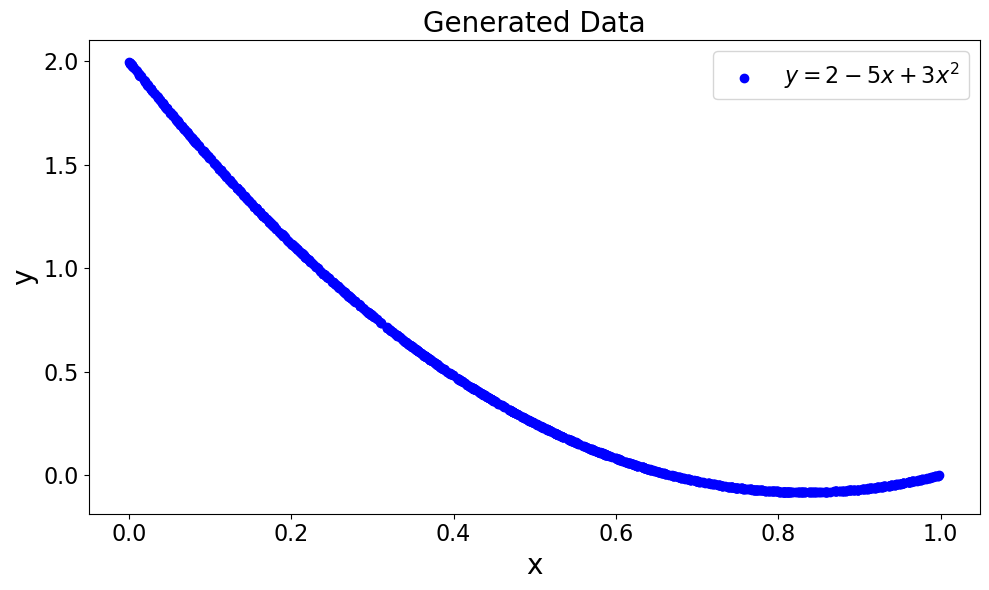

In [9]:
#generate data
np.random.seed(5)
n = 1000 #nr of samples
x = np.random.rand(n)
x = np.reshape(x,(-1,1))
y = 2 - 5*x + 3*(x**2)
y = np.reshape(y,(-1,1))

#set up design matrix
p=2
X = np.zeros((n,(p+1)))
X[:,0] = 1
for a in range(1,p+1):
    X[:,a] = np.power(x,a).T
#Remove intercept: optional
#X = X[:,1:p+1]


plt.figure(figsize=(10, 6))
plt.scatter(x, y, c='blue', label='$y = 2 - 5x + 3x^2$')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Generated Data', fontsize=20)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.savefig('./Figures/data.png', dpi = 600)
plt.show()


Using the class to try different learning rates and epochs and plotting these as seaborn figures. Note that the results folder contains more figures of these kind, whicht test different optimisers, batch sizes, and $\lambda$ for Ridge regression, thus fulfilling part a of the project description.

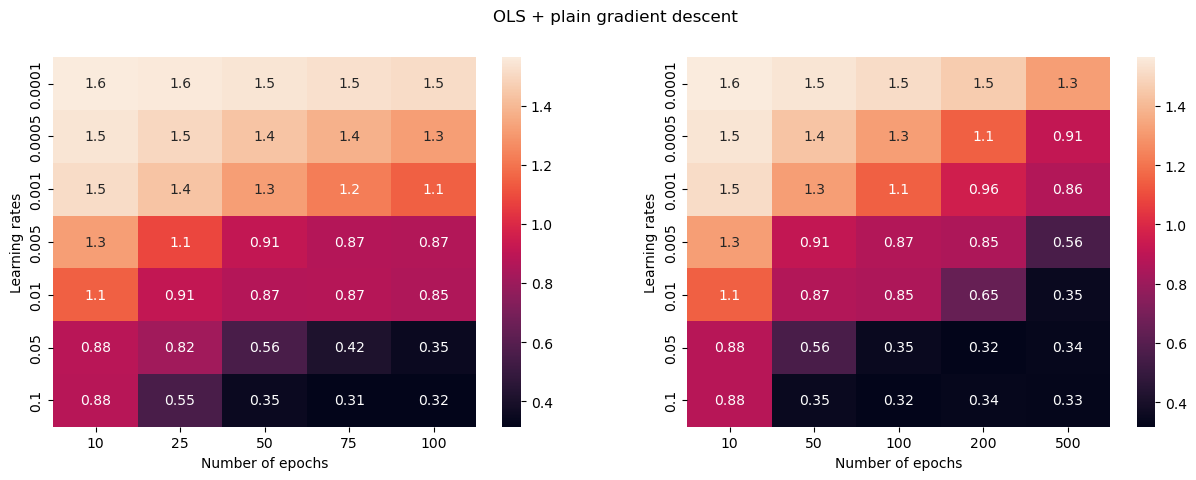

In [10]:
rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
epochs = [10, 25, 50, 75, 100]

X_train, X_test, y_train, y_test = train_test_split(X, y)

data = np.zeros([len(rates),len(epochs)])

for i in range(len(rates)):
    rate = rates[i]
    for j in range(len(epochs)):
        ep = epochs[j]
        betas = GradientDescent(X_train,y_train).__plain__(rate, ep, 'OLS', 0, 'None')
        y_prediction = X_test @ betas
        data[i,j] = Metrics(y_test,y_prediction).mean_squared_error()

df1 = pd.DataFrame(data,index = rates, columns = epochs)


rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
epochs = [10, 50, 100, 200, 500]

data = np.zeros([len(rates),len(epochs)])

for i in range(len(rates)):
    rate = rates[i]
    for j in range(len(epochs)):
        ep = epochs[j]
        betas = GradientDescent(X_train,y_train).__plain__(rate, ep, 'OLS', 0, 'None')
        y_prediction = X_test @ betas
        data[i,j] = Metrics(y_test,y_prediction).mean_squared_error()

df2 = pd.DataFrame(data,index = rates, columns = epochs)

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_figwidth(15)
fig.suptitle('OLS + plain gradient descent')

ax = sns.heatmap(df1, ax = ax1, annot=True)
ax1.set(xlabel="Number of epochs", ylabel="Learning rates")

ax2 = sns.heatmap(df2, ax = ax2, annot=True)
ax2.set(xlabel="Number of epochs", ylabel="Learning rates")

plt.show()


### Preamble for b-d

The NeuralNetwork class below represents our self-written Neural Network code with back-propagation implemented by hand as done for the exercises in week 43. It is flexible in its definition of the number of hidden layers by taking a list of numbers (=number of nodes) as inputs. It also allows a list of activation functions to be passed so that different activation functions can be tried out (part c) and so the output can be changed to be for regression (part b) or classification (part d). 

After our own neural network class we also define a tensor flow model to compare our own model against.

In [11]:
# Define activation functions and their derivatives
def relu(x):
    return np.maximum(0, x)

def ReLU_derivative(x):
    return np.where(x > 0, 1, 0)

def leakyrelu(x):
    return np.where(x > 0, x, x * 0.01)

def LeakyReLU_derivative(x):
    return np.where(x > 0, 1, 0.01)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def linear(x):
    return x

def Linear_derivative(x):
    return np.ones_like(x)

In [12]:
class NeuralNetwork:
    """
    A class used to represent a Neural Network.
    Attributes
    ----------
    X_data_full : np.ndarray
        The input data for training.
    Y_data_full : np.ndarray
        The target data for training.
    X_test : np.ndarray
        The input data for testing.
    Y_test : np.ndarray
        The target data for testing.
    n_inputs : int
        The number of input samples.
    n_features : int
        The number of features in the input data.
    n_hidden_layers : list
        A list containing the number of neurons in each hidden layer.
    n_output : int
        The number of output neurons.
    epochs : int
        The number of epochs for training.
    batch_size : int
        The size of each batch for training.
    iterations : int
        The number of iterations per epoch.
    eta : float
        The learning rate.
    lmbd : float
        The regularization parameter.
    optimiser : str
        The optimization algorithm to use.
    activation_func : list
        A list of activation functions for each layer.
    loss_func : str
        The loss function to use.
    Methods
    -------
    create_biases_and_weights():
        Initializes the weights and biases for the network.
    feed_forward(input_data, layers, activation_func):
        Performs a feed-forward pass through the network.
    predict(X):
        Predicts the output for given input data.
    loss_function(inputs, targets):
        Computes the loss for given inputs and targets.
    backpropagation(input, layers, activation_funcs, target):
        Performs backpropagation to compute gradients.
    update_weights(layers, layer_grads, learning_rate, optimiser='SGD', beta1=0.9, beta2=0.999, epsilon=1e-8):
        Updates the weights and biases using the computed gradients.
    fit():
        Trains the neural network on the training data.
    training_loss():
        Returns the training loss over epochs.
    val_loss():
        Returns the validation loss over epochs.
    plot_loss():
        Plots the training and validation loss over epochs.
    """

    def __init__(
        self,
        X_data,
        Y_data,
        X_test,
        Y_test,
        n_hidden_layers=[50],
        activation_func=[relu],
        epochs=10,
        batch_size=100,
        loss_func='MSE',
        optimiser='None',
        eta=0.1,
        lmbd=0.0,
        momentum=0.9):

        self.X_data_full = X_data
        self.Y_data_full = Y_data
        self.X_test = X_test
        self.Y_test = Y_test

        # Number of samples and features
        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]

        self.n_hidden_layers = n_hidden_layers
        self.n_output = Y_data.shape[1]

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        self.optimiser = optimiser
        self.activation_func = activation_func
        self.loss_func = loss_func
        self.momentum = momentum

    def create_biases_and_weights(self):
        layers = []

        i_size = self.n_features
        for layer_output_size in self.n_hidden_layers + [self.n_output]:
            W = np.random.randn(layer_output_size, i_size)
            b = np.random.randn(layer_output_size)
            
            layers.append((W, b))
            i_size = layer_output_size
        return layers

    def feed_forward(self, input_data, layers, activation_func):
        layers_input = []
        zs = []
        a = input_data
        for (W, b), activation in zip(layers, activation_func):
            layers_input.append(a)
            z = a @ W.T + b
            a = activation(z)
            zs.append(z)
        
        return layers_input, zs, a
    
    def predict(self, X):
        # Simple feed forward pass
        a = X
        for (W, b), activation_func in zip(self.layers, self.activation_func):
            z = a @ W.T + b
            a = activation_func(z)
        return a

    def loss_function(self, inputs, targets):
        prediction = self.predict(inputs)
        if self.loss_func == 'MSE':
            return np.mean((targets - prediction) ** 2)
        elif self.loss_func == 'CrossEntropy':
            return -np.mean(targets * np.log(prediction + 1e-15))
        else:
            raise ValueError(f'Unknown loss function: {self.loss_func}')

    def backpropagation(self, input, layers, activation_funcs, target):
        layer_inputs, zs, predict = self.feed_forward(input, layers, activation_funcs)

        layer_grads = [(None, None) for layer in layers]

        for i in reversed(range(len(layers))):
            if i == len(layers) - 1:
                dC_da = -(target - predict)
            else:
                (W_next, b_next) = layers[i + 1]
                dC_da = dC_dz @ W_next

            z = zs[i]
            a_prev = layer_inputs[i]

            if activation_funcs[i] == relu:
                dC_dz = dC_da * ReLU_derivative(z)
            elif activation_funcs[i] == sigmoid:
                dC_dz = dC_da * sigmoid_derivative(z)
            elif activation_funcs[i] == linear:
                dC_dz = dC_da * Linear_derivative(z)
            elif activation_funcs[i] == leakyrelu:
                dC_dz = dC_da * LeakyReLU_derivative(z)
            else:
                raise ValueError(f'Unknown activation function: {activation_funcs[i]}')

            dC_dW = dC_dz.T @ a_prev
            dC_db = np.sum(dC_dz, axis=0)

            layer_grads[i] = (dC_dW, dC_db)

        return layer_grads
        
    def update_weights(self, layers, layer_grads, learning_rate, optimiser='SGD', beta2=0.999, epsilon=1e-8):
        if self.lmbd > 0:
            for idx, ((W, b), (dC_dW, dC_db)) in enumerate(zip(layers, layer_grads)):
                dC_dW += self.lmbd * W
        if optimiser == 'SGDwithoutMomentum':
            for idx, ((W, b), (dC_dW, dC_db)) in enumerate(zip(layers, layer_grads)):
                layers[idx] = (W - learning_rate * dC_dW, b - learning_rate * dC_db)

        elif optimiser == 'SGD':
            if not hasattr(self, 'v'):
                self.v = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]
            for idx, ((W, b), (dC_dW, dC_db)) in enumerate(zip(layers, layer_grads)):
                vW, vb = self.v[idx]
                vW = self.momentum * vW + (1 - self.momentum) * dC_dW
                vb = self.momentum * vb + (1 - self.momentum) * dC_db
                layers[idx] = (W - learning_rate * vW, b - learning_rate * vb)
                self.v[idx] = (vW, vb)

        elif optimiser == 'adam':
            if not hasattr(self, 'm'):
                self.m = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]
                self.v = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]
                self.t = 0
            self.t += 1
            for idx, ((W, b), (dC_dW, dC_db)) in enumerate(zip(layers, layer_grads)):
                mW, mb = self.m[idx]
                vW, vb = self.v[idx]
                mW = self.momentum * mW + (1 - self.momentum) * dC_dW
                mb = self.momentum * mb + (1 - self.momentum) * dC_db
                vW = beta2 * vW + (1 - beta2) * (dC_dW ** 2)
                vb = beta2 * vb + (1 - beta2) * (dC_db ** 2)
                mW_hat = mW / (1 - self.momentum ** self.t)
                mb_hat = mb / (1 - self.momentum ** self.t)
                vW_hat = vW / (1 - beta2 ** self.t)
                vb_hat = vb / (1 - beta2 ** self.t)
                layers[idx] = (W - learning_rate * mW_hat / (np.sqrt(vW_hat) + epsilon), b - learning_rate * mb_hat / (np.sqrt(vb_hat) + epsilon))
                self.m[idx] = (mW, mb)
                self.v[idx] = (vW, vb)

        elif optimiser == 'adagrad':
            if not hasattr(self, 'G'):
                self.G = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]

            for idx, ((W, b), (dC_dW, dC_db)) in enumerate(zip(layers, layer_grads)):
                GW, Gb = self.G[idx]
                GW += dC_dW ** 2
                Gb += dC_db ** 2
                layers[idx] = (W - learning_rate * dC_dW / np.sqrt(GW + epsilon), b - learning_rate * dC_db / np.sqrt(Gb + epsilon))
                self.G[idx] = (GW, Gb)
        
        
        elif optimiser == 'RMSprop':
            if not hasattr(self, 'G'):
                self.G = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]
            for idx, ((W, b), (dC_dW, dC_db)) in enumerate(zip(layers, layer_grads)):
                GW, Gb = self.G[idx]
                GW = self.momentum * GW + (1 - self.momentum) * dC_dW ** 2
                Gb = self.momentum * Gb + (1 - self.momentum) * dC_db ** 2
                layers[idx] = (W - learning_rate * dC_dW / np.sqrt(GW + epsilon), b - learning_rate * dC_db / np.sqrt(Gb + epsilon))
                self.G[idx] = (GW, Gb)
        else:
            raise ValueError(f'Unknown optimiser: {optimiser}')

        return layers

    def fit(self):
        self.validation_loss = np.zeros(self.epochs)
        self.train_loss = np.zeros(self.epochs)
        
        self.layers = self.create_biases_and_weights()

        for i in range(self.epochs):
            for j in range(self.iterations):
                batch_indices = np.random.choice(len(self.X_data_full), size=self.batch_size, replace=False)
                X_batch = self.X_data_full[batch_indices]
                Y_batch = self.Y_data_full[batch_indices]

                layer_grads = self.backpropagation(X_batch, self.layers, self.activation_func, Y_batch)
                self.layers = self.update_weights(self.layers, layer_grads, self.eta, self.optimiser)

            self.train_loss[i] += self.loss_function(self.X_data_full, self.Y_data_full) 
            self.validation_loss[i] += self.loss_function(self.X_test, self.Y_test) 


    def training_loss(self):
        return self.train_loss
    
    def val_loss(self):
        return self.validation_loss
    
    def accuracy(self):
        Y_pred_train = self.predict(self.X_data_full)
        Y_pred_test = self.predict(self.X_test)
        return np.mean(np.argmax(Y_pred_train, axis=1) == np.argmax(self.Y_data_full, axis=1)), np.mean(np.argmax(Y_pred_test, axis=1) == np.argmax(self.Y_test, axis=1))
    
    def evaluate(self):
        return [Metrics(self.predict(self.X_data_full), self.Y_data_full).mean_squared_error(),
                Metrics(self.predict(self.X_test), self.Y_test).mean_squared_error(),
                Metrics(self.predict(self.X_data_full), self.Y_data_full).r2_score(),
                Metrics(self.predict(self.X_test), self.Y_test).r2_score()]
    
    def plot_loss(self):
        plt.plot(np.arange(self.epochs), self.train_loss, label='Training loss')
        plt.plot(np.arange(self.epochs), self.validation_loss, label='Validation loss')
        plt.legend()
        plt.show()

Code to perform grid search on the custom NN:

In [32]:
class GridSearchNN:
    """
    A class to perform grid search for a neural network model.
    Attributes:
    -----------
    X_train : array-like
        Training data features.
    y_train : array-like
        Training data labels.
    X_test : array-like
        Test data features.
    y_test : array-like
        Test data labels.
    param_grid : dict
        Dictionary with parameters names (`str`) as keys and lists of parameter settings to try as values.
    epochs : int
        Number of epochs to train the model.
    Methods:
    --------
    _grid_search(item):
        Performs grid search for a single set of hyperparameters.
    run_grid_search():
        Runs the grid search over all combinations of hyperparameters.
    """

    def __init__(self,
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    param_grid,
                    loss_func='MSE',
                    epochs = 10
                 ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.param_grid = param_grid
        self.epochs = epochs
        self.loss_func = loss_func

    def _grid_search(self, item):
        
        model = NeuralNetwork(X_data=self.X_train,
                        Y_data=self.y_train,
                        X_test=self.X_test,
                        Y_test=self.y_test,
                        n_hidden_layers=item['n_hidden_layers'],
                        epochs=self.epochs,
                        batch_size=item['batch_size'],
                        eta=item['eta'],
                        lmbd=item['lmbd'],
                        optimiser=item['optimiser'],
                        loss_func=self.loss_func,
                        activation_func=item['activation_func'])

        model.fit()
        return {
            'eta': item['eta'],
            'lmbd': item['lmbd'],
            'epochs': self.epochs,
            'batch_size': item['batch_size'],
            'n_hidden_layers': item['n_hidden_layers'],
            'activation_func': [func.__name__ for func in item['activation_func']],
            'optimiser': item['optimiser'],
            'training_loss': model.training_loss()[-1],
            'validation_loss': model.val_loss()[-1],
            'training_accuracy': model.accuracy()[0],
            'validation_accuracy': model.accuracy()[1]
        }
    
    def run_grid_search(self):
        results = []

        param_list = list(ParameterGrid(self.param_grid))
        results = Parallel(n_jobs=mp.cpu_count())(delayed(self._grid_search)(item) for item in tqdm(param_list))

        return results

Defining the TensorFlow model:

In [33]:
class TensorFlowDenseModel:
    """
    A class used to represent a TensorFlow Dense Model.
    Attributes
    ----------
    X_train : np.ndarray
        Training data features.
    y_train : np.ndarray
        Training data labels.
    X_test : np.ndarray
        Testing data features.
    y_test : np.ndarray
        Testing data labels.
    model : tf.keras.Sequential
        The TensorFlow Sequential model.
    verbose : int
        Verbosity mode.
    Methods
    -------
    __init__(layers, activation='relu', output_activation='linear', X_train=None, y_train=None, X_test=None, y_test=None, loss='mse', optimizer='adam', verbose=0)
        Initializes the TensorFlowDenseModel with the given parameters.
    train(epochs=100, batch_size=32)
        Trains the model using the training data.
    predict(X)
        Predicts the output for the given input data.
    plot_loss()
        Plots the training and validation loss over epochs.
    """
    def __init__(self,
                 layers, 
                 activation=['relu'], 
                 output_activation='linear',
                 X_train=None,
                 y_train=None,
                 X_test=None,
                 y_test=None, 
                 loss='mse',
                 eta = 0.1, 
                 optimizer='adam', 
                 verbose=0):
        
        import tensorflow as tf

        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.eta = eta
        self.model = tf.keras.Sequential()
        self.verbose = verbose

        if optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.eta)
        elif optimizer == 'SGD':
            optimizer = tf.keras.optimizers.SGD(learning_rate=self.eta, momentum=0.9)
        elif optimizer == 'SGDwithoutMomentum':
            optimizer = tf.keras.optimizers.SGD(learning_rate=self.eta, momentum=0.0)
        elif optimizer == 'RMSprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.eta)
        elif optimizer == 'adagrad':
            optimizer = tf.keras.optimizers.Adagrad(learning_rate=self.eta)
        elif optimizer == 'adadelta':
            optimizer = tf.keras.optimizers.Adadelta(learning_rate=self.eta)
        elif optimizer == 'adamax':
            optimizer = tf.keras.optimizers.Adamax(learning_rate=self.eta)
        else:
            raise ValueError(f'Unknown optimizer: {optimizer}')
        
        for units, activation_ in zip(layers, activation):
            if activation_ == 'leakyrelu':
                self.model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
                continue
            self.model.add(tf.keras.layers.Dense(units, activation=activation_))
        
        if output_activation == 'leakyrelu':
            self.model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
            self.model.add(tf.keras.layers.Dense(self.y_train.shape[1]))
        else:
            self.model.add(tf.keras.layers.Dense(self.y_train.shape[1], activation=output_activation))
 
        self.model.compile(loss=loss, optimizer=optimizer)
    
    def train(self, epochs=100, batch_size=32):
        self.history = self.model.fit(self.X_train,
                                      self.y_train, 
                                      epochs=epochs, 
                                      batch_size=batch_size, 
                                      validation_data=(self.X_test, self.y_test), 
                                      verbose=self.verbose,
                                      workers=-1
                                      )
    
    def predict(self, X):
        return self.model.predict(X)
    
    def accuracy(self):
        Y_pred_train = self.predict(self.X_train)
        Y_pred_test = self.predict(self.X_test)
        return np.mean(np.argmax(Y_pred_train, axis=1) == np.argmax(self.y_train, axis=1)), np.mean(np.argmax(Y_pred_test, axis=1) == np.argmax(self.y_test, axis=1))
    
    def evaluate(self):
        return [Metrics(self.predict(self.X_train), self.y_train).mean_squared_error(),
                Metrics(self.predict(self.X_test), self.y_test).mean_squared_error(),
                Metrics(self.predict(self.X_train), self.y_train).r2_score(),
                Metrics(self.predict(self.X_test), self.y_test).r2_score()]
    
    def plot_loss(self):
        plt.plot(self.history.history['loss'], label='loss')
        if 'val_loss' in self.history.history:
            plt.plot(self.history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

Code to perform the grid search on the TensorFlow NN:

In [34]:
class GridSearchTF:
    """
    A class to perform grid search for hyperparameter tuning using TensorFlow models.
    Attributes:
    -----------
    X_train : array-like
        Training data features.
    y_train : array-like
        Training data labels.
    X_test : array-like
        Testing data features.
    y_test : array-like
        Testing data labels.
    param_grid : dict
        Dictionary with parameters names (str) as keys and lists of parameter settings to try as values.
    epochs : int
        Number of epochs to train the model.
    Methods:
    --------
    _grid_search(item):
        Trains a TensorFlow model with the given hyperparameters and returns the training and validation loss.
    run_grid_search():
        Runs the grid search over the parameter grid and returns the results.
    """
    
    def __init__(self,
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    param_grid,
                    epochs,
                    loss='mse',
                    verbose=0
                 ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.param_grid = param_grid
        self.epochs = epochs
        self.loss = loss
        self.verbose = verbose    
    def _grid_search(self, item):
        model = TensorFlowDenseModel(layers=item['layers'],
                                     activation=item['activation_func'],
                                     output_activation=item['output_activation'],
                                     X_train=self.X_train,
                                     y_train=self.y_train,
                                     X_test=self.X_test,
                                     y_test=self.y_test,
                                     loss=self.loss,
                                     optimizer=item['optimiser'],
                                     verbose=self.verbose)
        model.train(epochs=self.epochs, batch_size=item['batch_size'])
        
        return {
            'layers': item['layers'],
            'activation': item['activation_func'],
            'output_activation': item['output_activation'],
            'batch_size': item['batch_size'],
            'optimizer': item['optimiser'],
            'training_loss': model.history.history['loss'][-1],
            'validation_loss': model.history.history['val_loss'][-1],
            'accuracy_train': model.accuracy()[0],
            'accuracy_test': model.accuracy()[1]
        }
    
    def run_grid_search(self):
        results = []

        param_list = list(ParameterGrid(self.param_grid))
        results = Parallel(n_jobs=mp.cpu_count())(delayed(self._grid_search)(item) for item in tqdm(param_list))

        return results
    

### Part b

The code below uses first our own neural network on the polynomial used in part a. We then apply the tensorflow model for comparison. The same is done for the Franke function in order to compare against our results from Project 1. Grid search is applied to the custom NN and then these parameters are input into the TensorFlow model for comparison.

Defining the parameter grid that will be used in regression grid search:

In [35]:
param_grid = {'eta': [0.1, 0.001, 0.00001],
            'lmbd': [0.1, 0.001, 0.00001],
            'batch_size': [32, 64, 128],
            'n_hidden_layers': [[10],
                                [30],
                                [50]
            ],
            'activation_func': [[relu, linear],
                                [leakyrelu, linear], 
                                [sigmoid, linear], 
                                [linear, linear], 
                                [relu, relu], 
                                [leakyrelu, leakyrelu], 
                                [sigmoid, sigmoid]],
            'optimiser': ['SGDwithoutMomentum',
                          'SGD', 
                          'adam', 
                          'adagrad', 
                          'RMSprop']
            }

In [39]:
# Generate data
np.random.seed(5)
n = 1000  # number of samples
x = np.random.rand(n, 1)
y = 2 - 5*x + 3*np.power(x, 2)

# Set up design matrix
p = 5
X = np.hstack([np.ones((n, 1))] + [np.power(x, a) for a in range(1, p+1)])

# Optional: Remove intercept
X = X[:, 1:p+1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
# Grid search for Neural Network:
grid_search = GridSearchNN(X_train, y_train, X_test, y_test, param_grid, epochs=300)
results = grid_search.run_grid_search()
df_results = pd.DataFrame(results)
df_results.drop(['training_accuracy', 'validation_accuracy'], axis=1, inplace=True)
clear_output()
df_results.to_csv('grid_search_results_simple_expression.csv', index=False)

Best parameters: {
    "eta": 0.001,
    "lmbd": 0.001,
    "epochs": 300,
    "batch_size": 64,
    "n_hidden_layers": [
        30
    ],
    "activation_func": [
        "linear",
        "linear"
    ],
    "optimiser": "SGD",
    "training_loss": 9.936576452178678e-07,
    "validation_loss": 8.178893323482924e-07
}


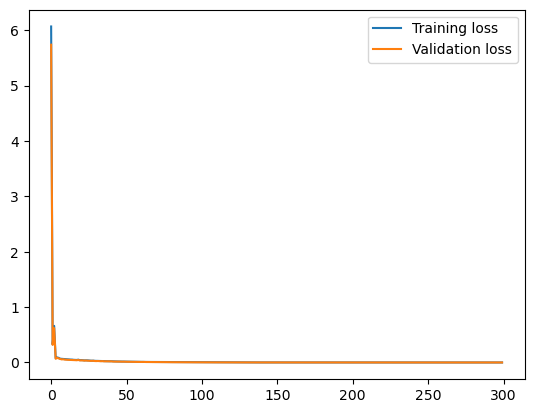

Training loss: 0.00016962764874961137
Validation loss: 0.00015472083489881882
Training R2: 0.9995774910544015
Validation R2: 0.9996106910339461


In [41]:
# Grid search results for custom Neural Network model:
best_params = df_results.dropna().sort_values('validation_loss').iloc[0].to_dict()
print('Best parameters:', json.dumps(best_params, indent=4))
model = NeuralNetwork(X_data=X_train,
                        Y_data=y_train,
                        X_test=X_test,
                        Y_test=y_test,
                        n_hidden_layers=best_params['n_hidden_layers'],
                        epochs=300,
                        batch_size=best_params['batch_size'],
                        loss_func='MSE',
                        optimiser=best_params['optimiser'],
                        activation_func=[globals()[func] for func in best_params['activation_func']],
                        eta=best_params['eta'],
                        lmbd=best_params['lmbd'])
model.fit()
model.plot_loss()
print('Training loss:', model.training_loss()[-1])
print('Validation loss:', model.val_loss()[-1])
print('Training R2:', model.evaluate()[2])
print('Validation R2:', model.evaluate()[3])

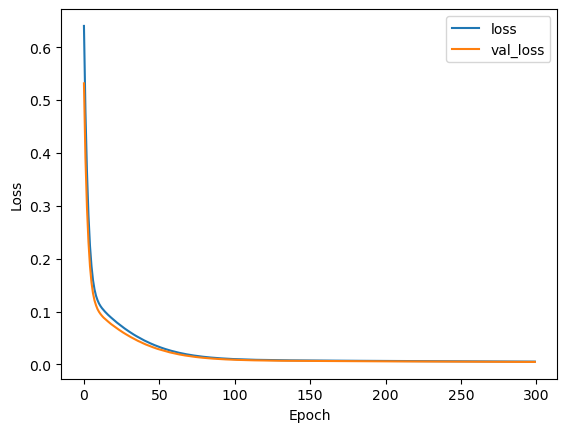

Training loss: 0.005380206275731325
Validation loss: 0.0047898064367473125
7/7 [==============================] - 0s 609us/step
Training R2: 0.9862494409692534
7/7 [==============================] - 0s 680us/step
Validation R2: 0.986987738811058


In [44]:
model_tf = TensorFlowDenseModel(layers=best_params['n_hidden_layers'],
                                activation=best_params['activation_func'],
                                output_activation = best_params['activation_func'][-1],
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss='mse',
                                eta=best_params['eta'],
                                optimizer=best_params['optimiser'],
                                verbose=0)
model_tf.train(epochs=300, batch_size=best_params['batch_size'])
model_tf.plot_loss()
print('Training loss:', model_tf.history.history['loss'][-1])
print('Validation loss:', model_tf.history.history['val_loss'][-1])
print('Training R2:', model_tf.evaluate()[2])
print('Validation R2:', model_tf.evaluate()[3])

32/32 [==============================] - 0s 688us/step


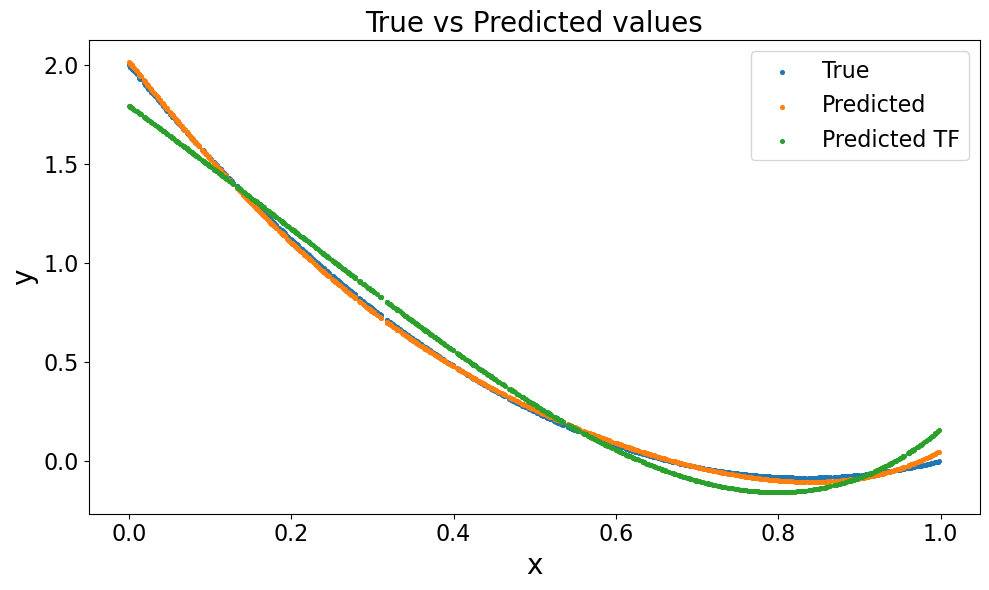

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='True', s = 7)
plt.scatter(x, model.predict(X), label='Predicted', s=7)
plt.scatter(x, model_tf.predict(X), label='Predicted TF', s=7)
plt.legend(fontsize=16)
plt.xlabel('x', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('y', fontsize=20)
plt.title('True vs Predicted values', fontsize=20)
plt.tight_layout()
plt.savefig('./Figures/true_vs_pred_polynomial_data.png', dpi = 600)
plt.show()

Repeating it for the Franke function:

In [36]:
# Make Franke function data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x,y = np.meshgrid(x, y)
z = DataGenerator(x,y).FrankeFunction()

X = determine_X(5, np.ravel(x), np.ravel(y))
X_train, X_test, y_train, y_test = prep_train_test(X, np.ravel(z), train_size=0.8)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

# Grid search for Neural Network:
grid_search = GridSearchNN(X_train, y_train, X_test, y_test, param_grid, epochs=300)
results = grid_search.run_grid_search()
df_results = pd.DataFrame(results)
df_results.drop(['training_accuracy', 'validation_accuracy'], axis=1, inplace=True)
clear_output()
df_results.to_csv('grid_search_results_frankie_function.csv', index=False)

Best parameters: {
    "eta": 0.1,
    "lmbd": 1e-05,
    "epochs": 300,
    "batch_size": 32,
    "n_hidden_layers": [
        50
    ],
    "activation_func": [
        "sigmoid",
        "linear"
    ],
    "optimiser": "adam",
    "training_loss": 0.00045604213666479014,
    "validation_loss": 0.0004981303011380104
}


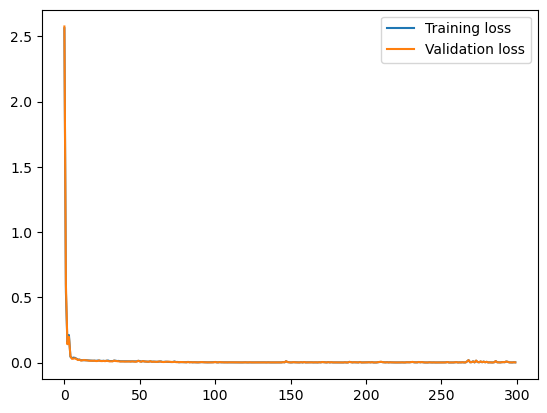

Training loss: 0.0014684879860693404
Validation loss: 0.0011293868788274403
Training R2: 0.9900753202597626
Validation R2: 0.9925085258982359


In [37]:
# Grid search results for custom Neural Network model:
best_params = df_results.dropna().sort_values('validation_loss').iloc[0].to_dict()
print('Best parameters:', json.dumps(best_params, indent=4))
model = NeuralNetwork(X_data=X_train,
                        Y_data=y_train,
                        X_test=X_test,
                        Y_test=y_test,
                        n_hidden_layers=best_params['n_hidden_layers'],
                        epochs=300,
                        batch_size=best_params['batch_size'],
                        loss_func='MSE',
                        optimiser=best_params['optimiser'],
                        activation_func=[globals()[func] for func in best_params['activation_func']],
                        eta=best_params['eta'],
                        lmbd=best_params['lmbd'])
model.fit()
model.plot_loss()
print('Training loss:', model.training_loss()[-1])
print('Validation loss:', model.val_loss()[-1])
print('Training R2:', model.evaluate()[2])
print('Validation R2:', model.evaluate()[3])

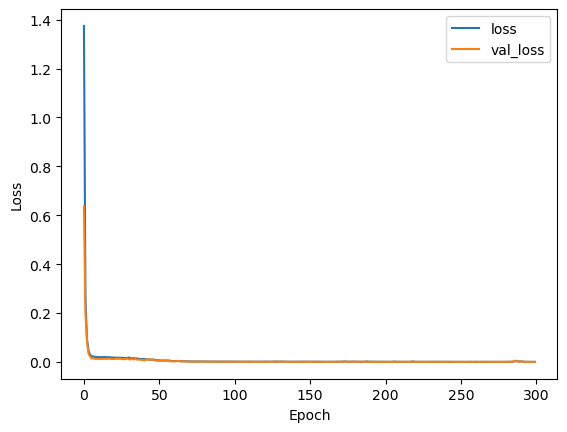

Training loss: 0.0003804133157245815
Validation loss: 0.0003627515980042517
3/3 [==============================] - 0s 946us/step
Training R2: 0.9963001115838976
3/3 [==============================] - 0s 928us/step
Validation R2: 0.9964618228499419


In [38]:
model_tf = TensorFlowDenseModel(layers=best_params['n_hidden_layers'],
                                activation=best_params['activation_func'],
                                output_activation=best_params['activation_func'][-1],
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss='mse',
                                eta=best_params['eta'],
                                optimizer=best_params['optimiser'],
                                verbose=0)
model_tf.train(epochs=300, batch_size=best_params['batch_size'])
model_tf.plot_loss()
print('Training loss:', model_tf.history.history['loss'][-1])
print('Validation loss:', model_tf.history.history['val_loss'][-1])
print('Training R2:', model_tf.evaluate()[2])
print('Validation R2:', model_tf.evaluate()[3])

In [ ]:
ols_regressor = OLS(x, y, z, poly_deg=7, sk_learn=False)
ols_regressor.fit()
ols_regressor.evaluate()

In [54]:
ridge_regressor = RidgeRegression(x, y, z, poly_deg=15,ld=1e-7)
ridge_regressor.fit()
ridge_regressor.evaluate()

[0.003924339686610003,
 0.0011713328865941629,
 0.9523888854412847,
 0.986145034515218]

In [55]:
frankie_plot = DataGenerator(x, y)
z_pred = np.reshape(model.predict(X), (20, 20))
z_pred_tf = np.reshape(model_tf.predict(X), (20, 20))
X_ols = determine_X(7, np.ravel(x), np.ravel(y))
z_ols_pred = ols_regressor.predict(X_ols).reshape(20, 20)
X_ridge = determine_X(15, np.ravel(x), np.ravel(y))
z_ridge_pred = ridge_regressor.predict(X_ridge).reshape(20, 20)

13/13 [==============================] - 0s 618us/step


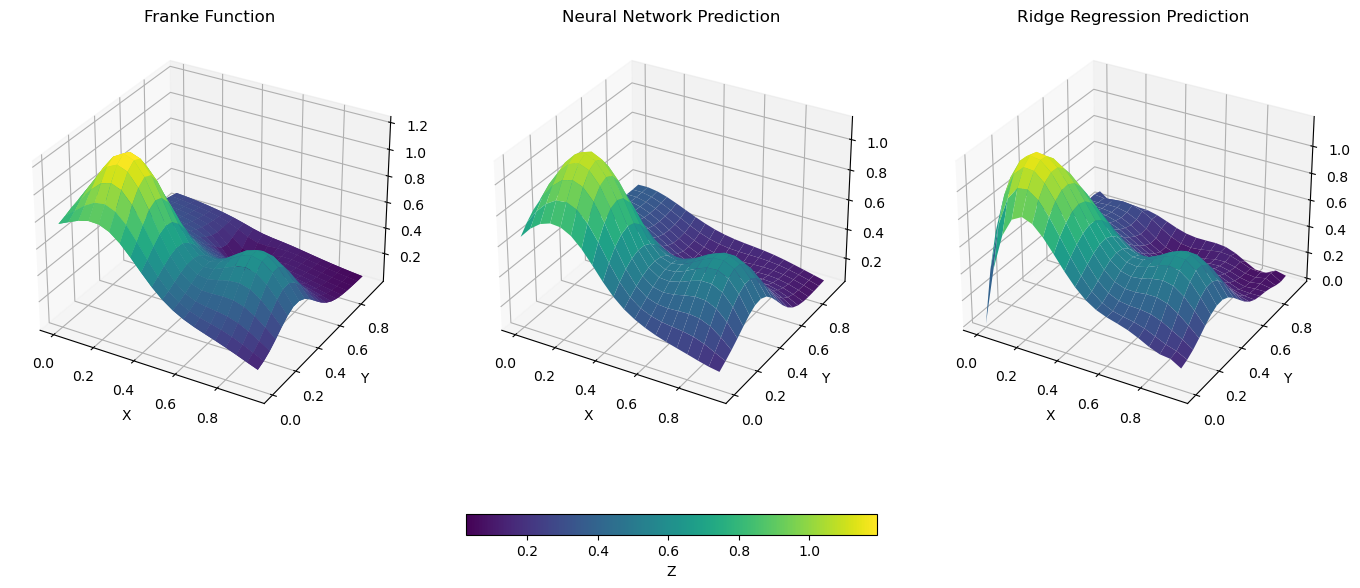

In [56]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

# Create one colormap for three axes
norm = plt.Normalize(vmin=frankie_plot.FrankeFunction().min(), vmax=frankie_plot.FrankeFunction().max())
cmap = cm.viridis

# Plot the surfaces with the same colormap
ax1.plot_surface(x, y, frankie_plot.FrankeFunction(), cmap='viridis', norm=norm)
ax1.set_title('Franke Function')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

ax2.plot_surface(x, y, z_pred, cmap='viridis', norm=norm)
ax2.set_title('Neural Network Prediction')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

ax3.plot_surface(x, y, z_ridge_pred, cmap='viridis', norm=norm)
ax3.set_title('Ridge Regression Prediction')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')

plt.tight_layout()
fig.colorbar(ax1.plot_surface(x, y, frankie_plot.FrankeFunction(), cmap='viridis'), ax=[ax1, ax2, ax3], orientation='horizontal', shrink=0.3, aspect=20, label='Z')

plt.savefig('./Figures/frankie_function_predictions.png', dpi = 600, bbox_inches='tight')
plt.show()

### Part c

Below, the ReLU and Leaky ReLU functions are tested on regression using our custom NN. Note however that we have studied the activation functions more extensively in the paper by including it in our grid search.

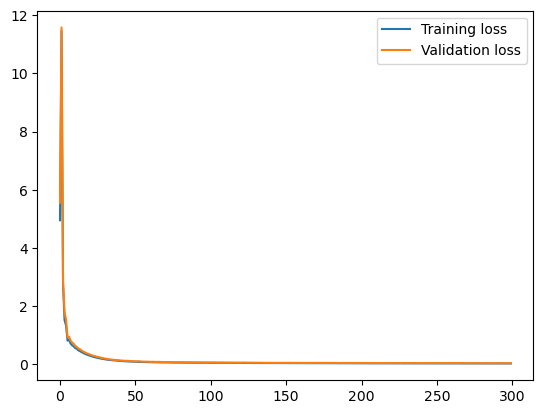

Training loss: 0.030858959040052925
Validation loss: 0.03773125784599287
Training R2: 0.6809888009933994
Validation R2: 0.5910574742501757


In [ ]:
model = NeuralNetwork(X_data=X_train,
                      Y_data = y_train, 
                      X_test=X_test,
                      Y_test=y_test,
                      n_hidden_layers=[50],
                      epochs=300, 
                      batch_size=32, 
                      eta=0.0001, 
                      lmbd=0.1,
                      optimiser='SGD', 
                      activation_func=[relu, linear])
model.fit()
model.plot_loss()
print('Training loss:', model.training_loss()[-1])
print('Validation loss:', model.val_loss()[-1])
print('Training R2:', model.evaluate()[2])
print('Validation R2:', model.evaluate()[3])

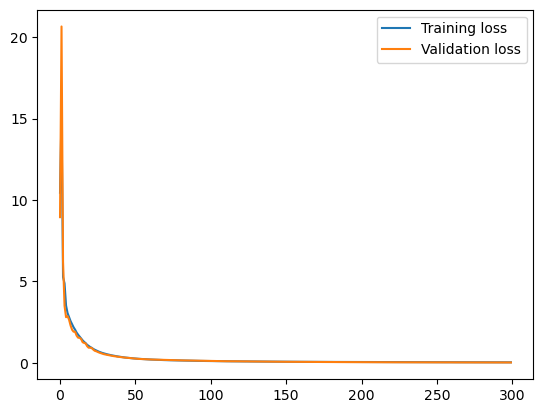

Training loss: 0.03808090371990371
Validation loss: 0.02832158696434629
Training R2: 0.6634173772950198
Validation R2: 0.6756534877426521


In [34]:
model = NeuralNetwork(X_data=X_train,
                      Y_data = y_train, 
                      X_test=X_test,
                      Y_test=y_test,
                      n_hidden_layers=[50],
                      epochs=300, 
                      batch_size=32, 
                      eta=0.0001, 
                      lmbd=0.1,
                      optimiser='SGD', 
                      activation_func=[leakyrelu, linear])
model.fit()
model.plot_loss()
print('Training loss:', model.training_loss()[-1])
print('Validation loss:', model.val_loss()[-1])
print('Training R2:', model.evaluate()[2])
print('Validation R2:', model.evaluate()[3])

### Part d

The code below uses our own NN for classification on the Iris dataset. We again perform a grid search and compare against TensorFlow. We also plot the confusion matrices for predictions on the test set. This is then repeated for the Wisconsin Breast Cancer data. 

Defining the parameters for the classification grid search

In [58]:
param_grid = {'eta': [0.1, 0.01, 0.001, 0.0001, 0.00001],
            'lmbd': [0.1, 0.001, 0.00001],
            'batch_size': [32, 64, 128],
            'n_hidden_layers': [[10],
                                [30],
                                [50]
            ],
            'activation_func': [[relu, sigmoid],
                                [sigmoid, sigmoid],
                                [linear, sigmoid],
                                [leakyrelu, sigmoid],
                                ],
            'optimiser': ['SGDwithoutMomentum',
                          'SGD', 
                          'adam', 
                          'adagrad', 
                          'RMSprop']
            }

In [57]:
iris = datasets.load_iris()
inputs = iris.data

# Since each prediction is a vector with a score for each of the three types of flowers,
# we need to make each target a vector with a 1 for the correct flower and a 0 for the others.
targets = np.zeros((len(iris.data), 3))
for i, t in enumerate(iris.target):
    targets[i, t] = 1


def accuracy(predictions, targets):
    one_hot_predictions = np.zeros(predictions.shape)

    for i, prediction in enumerate(predictions):
        one_hot_predictions[i, np.argmax(prediction)] = 1
    return accuracy_score(one_hot_predictions, targets)

In [59]:
np.random.seed(5)
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3, stratify=targets)
grid_search = GridSearchNN(X_train, y_train, X_test, y_test, param_grid, loss_func='CrossEntropy', epochs=300)
results = grid_search.run_grid_search()
df_results = pd.DataFrame(results)
df_results.drop(['training_loss', 'validation_loss'], axis=1, inplace=True)
clear_output()
df_results.to_csv('grid_search_results_iris_classification.csv', index=False)

Best parameters: {
    "eta": 0.01,
    "lmbd": 1e-05,
    "epochs": 300,
    "batch_size": 32,
    "n_hidden_layers": [
        10
    ],
    "activation_func": [
        "leakyrelu",
        "sigmoid"
    ],
    "optimiser": "adagrad",
    "training_accuracy": 0.9333333333333333,
    "validation_accuracy": 1.0
}


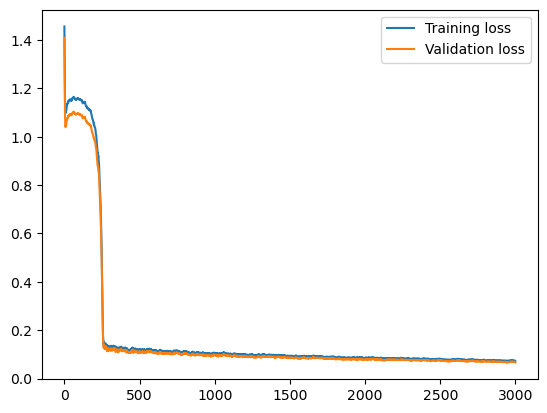

Training accuracy: 0.9619047619047619
Validation accuracy: 0.9777777777777777


In [63]:
# Grid search results for custom Neural Network model:
best_params = df_results.dropna().sort_values('validation_accuracy').iloc[-1].to_dict()
print('Best parameters:', json.dumps(best_params, indent=4))
model = NeuralNetwork(X_data=X_train,
                        Y_data=y_train,
                        X_test=X_test,
                        Y_test=y_test,
                        n_hidden_layers=best_params['n_hidden_layers'],
                        epochs=3000,
                        batch_size=best_params['batch_size'],
                        loss_func='CrossEntropy',
                        optimiser=best_params['optimiser'],
                        activation_func=[globals()[func] for func in best_params['activation_func']],
                        eta=best_params['eta'],
                        lmbd=best_params['lmbd'])
model.fit()
model.plot_loss()
print('Training accuracy:', model.accuracy()[0])
print('Validation accuracy:', model.accuracy()[1])

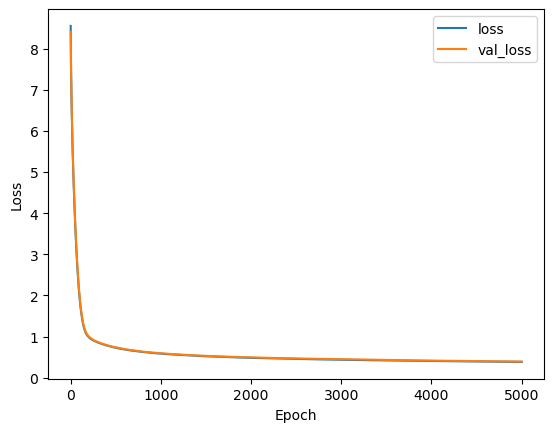

2/2 [==============================] - 0s 2ms/step
Training accuracy: 0.9428571428571428
2/2 [==============================] - 0s 2ms/step
Validation accuracy: 0.9777777777777777


In [61]:
model_tf = TensorFlowDenseModel(layers=best_params['n_hidden_layers'],
                                activation=best_params['activation_func'],
                                output_activation=best_params['activation_func'][-1],
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss='categorical_crossentropy',
                                eta=best_params['eta'],
                                optimizer=best_params['optimiser'],
                                verbose=0)
model_tf.train(epochs=5000, batch_size=best_params['batch_size'])
model_tf.plot_loss()
print('Training accuracy:', model_tf.accuracy()[0])
print('Validation accuracy:', model_tf.accuracy()[1])

2/2 [==============================] - 0s 2ms/step


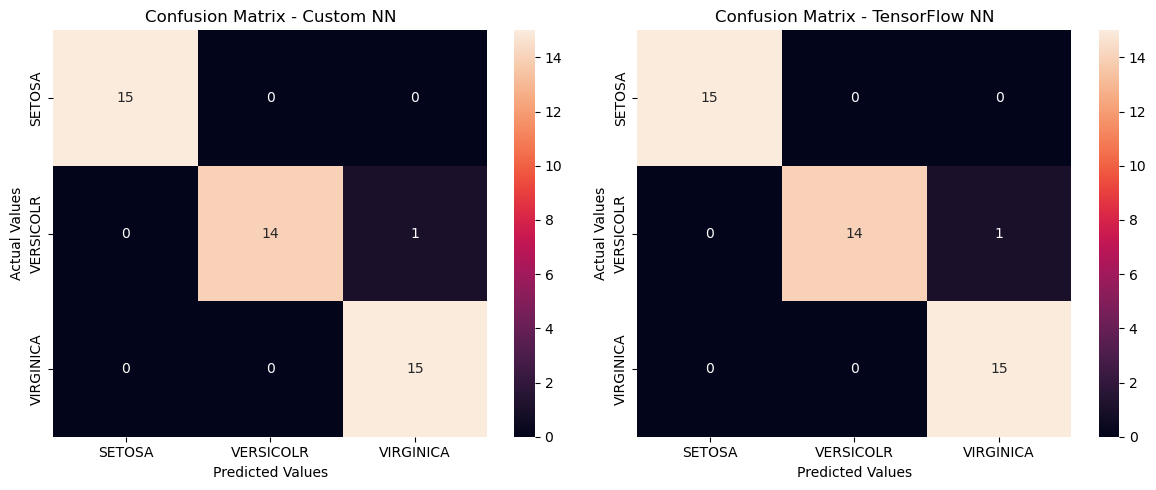

In [66]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
cm_tf = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_tf.predict(X_test), axis=1))
cm_df = pd.DataFrame(cm,
                     index = ['SETOSA','VERSICOLR','VIRGINICA'], 
                     columns = ['SETOSA','VERSICOLR','VIRGINICA'])
cm_tf_df = pd.DataFrame(cm_tf,
                     index = ['SETOSA','VERSICOLR','VIRGINICA'], 
                     columns = ['SETOSA','VERSICOLR','VIRGINICA'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_df, annot=True, ax=axes[0])
axes[0].set_title('Confusion Matrix - Custom NN')
axes[0].set_ylabel('Actual Values')
axes[0].set_xlabel('Predicted Values')

sns.heatmap(cm_tf_df, annot=True, ax=axes[1])
axes[1].set_title('Confusion Matrix - TensorFlow NN')
axes[1].set_ylabel('Actual Values')
axes[1].set_xlabel('Predicted Values')

plt.tight_layout()
plt.savefig('./Figures/iris_classification_confusion_matrices.png', dpi = 600)
plt.show()

Repeating for the breast cancer data:

In [ ]:
breast_cancer = datasets.load_breast_cancer()
inputs = breast_cancer.data

targets = np.zeros((len(breast_cancer.data), 2))
for i, t in enumerate(breast_cancer.target):
    targets[i, t] = 1

In [68]:
np.random.seed(5)
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3, stratify=targets)
grid_search = GridSearchNN(X_train, y_train, X_test, y_test, param_grid, loss_func='CrossEntropy', epochs=300)
results = grid_search.run_grid_search()
df_results = pd.DataFrame(results)
df_results.drop(['training_loss', 'validation_loss'], axis=1, inplace=True)
clear_output()
df_results.to_csv('grid_search_results_breast_cancer_classification.csv', index=False)

Best parameters: {
    "eta": 0.01,
    "lmbd": 0.001,
    "epochs": 300,
    "batch_size": 128,
    "n_hidden_layers": [
        10
    ],
    "activation_func": [
        "sigmoid",
        "sigmoid"
    ],
    "optimiser": "adam",
    "training_accuracy": 0.9472361809045227,
    "validation_accuracy": 0.9239766081871345
}


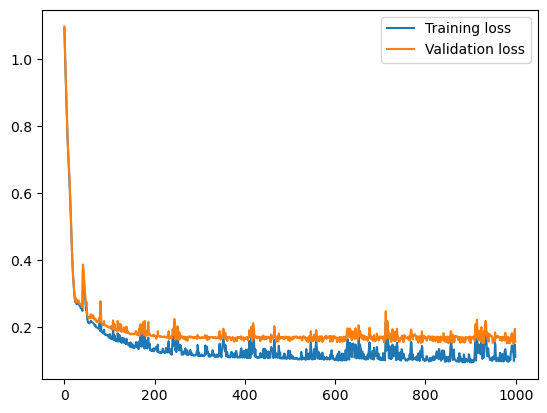

Training accuracy: 0.9422110552763819
Validation accuracy: 0.9122807017543859


In [69]:
# Grid search results for custom Neural Network model:
best_params = df_results.dropna().sort_values('validation_accuracy').iloc[-1].to_dict()
print('Best parameters:', json.dumps(best_params, indent=4))
model = NeuralNetwork(X_data=X_train,
                        Y_data=y_train,
                        X_test=X_test,
                        Y_test=y_test,
                        n_hidden_layers=best_params['n_hidden_layers'],
                        epochs=1000,
                        batch_size=best_params['batch_size'],
                        loss_func='CrossEntropy',
                        optimiser=best_params['optimiser'],
                        activation_func=[globals()[func] for func in best_params['activation_func']],
                        eta=best_params['eta'],
                        lmbd=best_params['lmbd'])
model.fit()
model.plot_loss()
print('Training accuracy:', model.accuracy()[0])
print('Validation accuracy:', model.accuracy()[1])

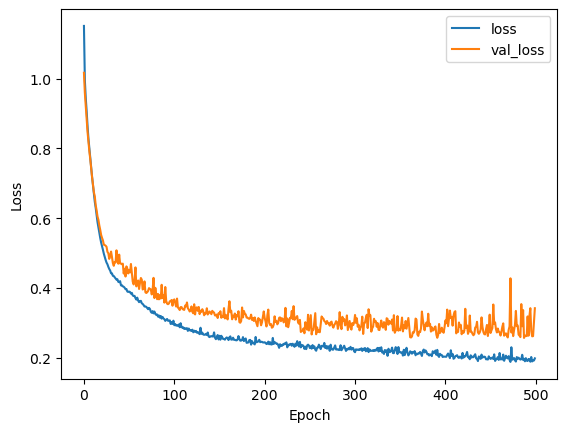

6/6 [==============================] - 0s 771us/step
Training accuracy: 0.9371859296482412
6/6 [==============================] - 0s 710us/step
Validation accuracy: 0.8947368421052632


In [99]:
model_tf = TensorFlowDenseModel(layers=best_params['n_hidden_layers'],
                                activation=best_params['activation_func'],
                                output_activation=best_params['activation_func'][-1],
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss='categorical_crossentropy',
                                eta=best_params['eta'],
                                optimizer=best_params['optimiser'],
                                verbose=0)
model_tf.train(epochs=500, batch_size=best_params['batch_size'])
model_tf.plot_loss()
print('Training accuracy:', model_tf.accuracy()[0])
print('Validation accuracy:', model_tf.accuracy()[1])

6/6 [==============================] - 0s 703us/step


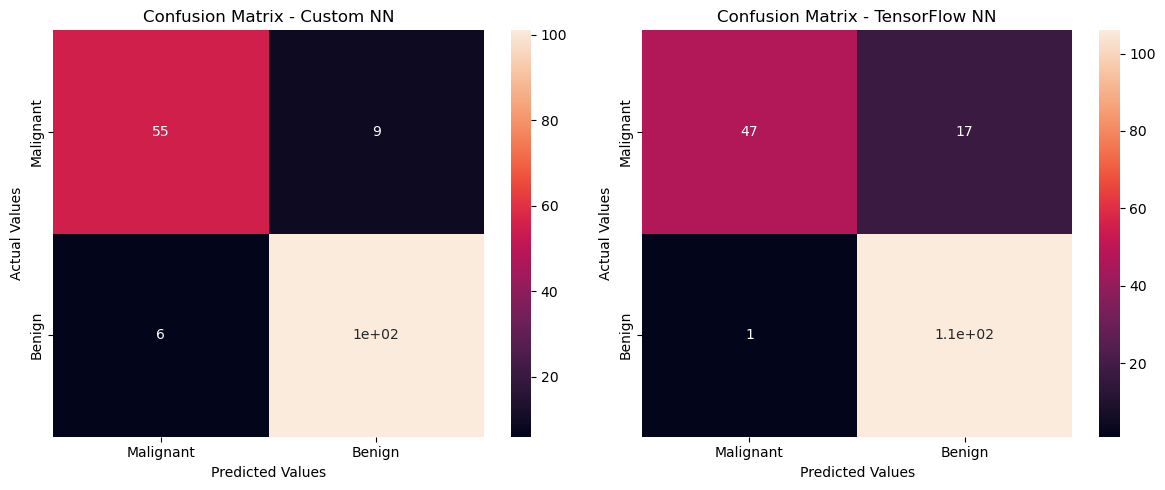

In [101]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
cm_tf = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_tf.predict(X_test), axis=1))
cm_df = pd.DataFrame(cm,
                     index = ['Malignant','Benign'], 
                     columns = ['Malignant','Benign'])
cm_tf_df = pd.DataFrame(cm_tf,
                     index = ['Malignant','Benign'], 
                     columns = ['Malignant','Benign'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_df, annot=True, ax=axes[0])
axes[0].set_title('Confusion Matrix - Custom NN')
axes[0].set_ylabel('Actual Values')
axes[0].set_xlabel('Predicted Values')

sns.heatmap(cm_tf_df, annot=True, ax=axes[1])
axes[1].set_title('Confusion Matrix - TensorFlow NN')
axes[1].set_ylabel('Actual Values')
axes[1].set_xlabel('Predicted Values')

plt.tight_layout()
plt.savefig('./Figures/breast_cancer_classification_confusion_matrices.png', dpi = 600)
plt.show()

### Part e

The code below performs logistic regression. Our custom logistic regression is performed by using our custom Neural Network code with 0 hidden layers. Thus, it reverts to a simple regression code. It is made logistic by using the sigmoid function. After, we use scikit learn logistic regression for the same purpose. The predictions on the test set made by both logistic regression codes are then plotted in confusion matrices. 

In [62]:
param_grid = {'eta': [0.1, 0.001, 0.00001],
            'lmbd': [0.1, 0.001, 0.00001],
            'batch_size': [32, 64, 128],
            'n_hidden_layers': [[1]],
            'activation_func': [[sigmoid, sigmoid]],
            'optimiser': ['SGDwithoutMomentum',
                          'SGD', 
                          'adam', 
                          'adagrad', 
                          'RMSprop']
            }

In [84]:
# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3, stratify=targets)
grid_search = GridSearchNN(X_train, y_train, X_test, y_test, param_grid, epochs=300)
results = grid_search.run_grid_search()
df_results = pd.DataFrame(results)
clear_output()
df_results.to_csv('grid_search_results_logistic_regression.csv', index=False)

Best parameters: {
    "eta": 0.001,
    "lmbd": 0.1,
    "epochs": 300,
    "batch_size": 64,
    "n_hidden_layers": [
        10
    ],
    "activation_func": [
        "sigmoid",
        "sigmoid"
    ],
    "optimiser": "RMSprop",
    "training_loss": 0.05264866657546351,
    "validation_loss": 0.05491773362705005,
    "training_accuracy": 0.9371859296482412,
    "validation_accuracy": 0.935672514619883
}


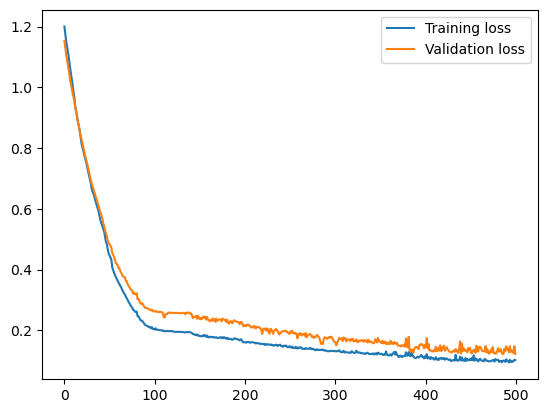

Training accuracy: 0.9396984924623115
Validation accuracy: 0.9122807017543859


In [90]:
# Grid search results for custom Neural Network model:
best_params = df_results.dropna().sort_values('validation_accuracy').iloc[-1].to_dict()
print('Best parameters:', json.dumps(best_params, indent=4))
model = NeuralNetwork(X_data=X_train,
                        Y_data=y_train,
                        X_test=X_test,
                        Y_test=y_test,
                        n_hidden_layers=best_params['n_hidden_layers'],
                        epochs=500,
                        batch_size=best_params['batch_size'],
                        loss_func='CrossEntropy',
                        optimiser=best_params['optimiser'],
                        activation_func=[globals()[func] for func in best_params['activation_func']],
                        eta=best_params['eta'],
                        lmbd=best_params['lmbd'])
model.fit()
model.plot_loss()
print('Training accuracy:', model.accuracy()[0])
print('Validation accuracy:', model.accuracy()[1])

In [93]:
model_lr = linear_model.LogisticRegression(max_iter=300)
model_lr.fit(X_train, np.argmax(y_train, axis=1))
y_pred = model_lr.predict(X_test)

print('Training accuracy:', accuracy_score(np.argmax(y_train, axis=1), model_lr.predict(X_train)))
print('Validation accuracy:', accuracy_score(np.argmax(y_test, axis=1), y_pred))

# accuracy_score(np.argmax(y_test, axis=1), y_pred)

Training accuracy: 0.957286432160804
Validation accuracy: 0.9298245614035088


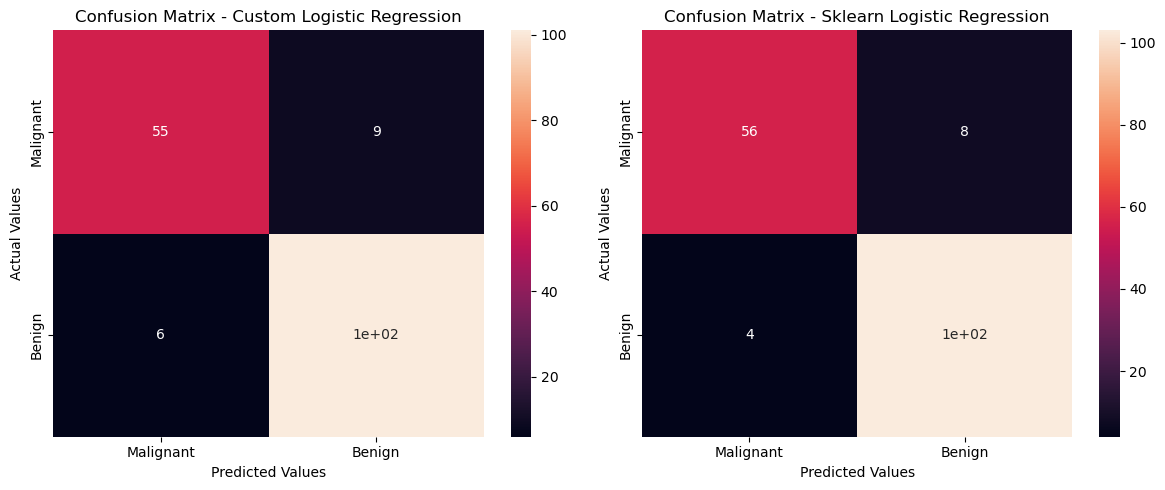

In [95]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
cm_tf = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Malignant','Benign'], 
                     columns = ['Malignant','Benign'])
cm_tf_df = pd.DataFrame(cm_tf,
                     index = ['Malignant','Benign'], 
                     columns = ['Malignant','Benign'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_df, annot=True, ax=axes[0])
axes[0].set_title('Confusion Matrix - Custom Logistic Regression')
axes[0].set_ylabel('Actual Values')
axes[0].set_xlabel('Predicted Values')

sns.heatmap(cm_tf_df, annot=True, ax=axes[1])
axes[1].set_title('Confusion Matrix - Sklearn Logistic Regression')
axes[1].set_ylabel('Actual Values')
axes[1].set_xlabel('Predicted Values')

plt.tight_layout()
plt.savefig('./Figures/logistic_regression_classification_confusion_matrices.png', dpi = 600)
plt.show()